# 02A-Tensorflow-PlayGround-Reimplementation

[Tensorflow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4&seed=0.11537&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Classification Homepage

![](../references/tfplayground_classification.PNG)

## Datasets

| circle        | exclusive_or           | guassian  |  spiral |
| ------------- |:-------------:| -----:| ---:|
| ![](../references/tfplayground_circle.png) | ![](../references/tfplayground_exclusive_or.png) | ![](../references/tfplayground_gaussian.png) | ![](../references/tfplayground_spiral.png) |


## Features

* Start, pause, resume and reset training
    * Set max epochs
* Adjust Learning rate (+ Optimizer)
* Adjust activation (overall except last layer)
    * First layer activation option also
* Add Regularization (Overall all weights, [L1, L2])
    * Adjusting regularization rate
* Choose datasets - circle, exclusive_or, gaussian, spiral
    * Ratio of training to test data
    * Noise level
* Choose Features - $X_1, X_2, X_1^2, X_2^2, X_1X_2, \sin(X_1), \sin(X_2)$
* Choose architecture - no of hidden layers, no or neurons in each layer
* Monitor/Plot learning curves
* Monitor/Plot decision boundary
    * Option to show test data
    * Option to discretize output

TODO: [Add type hints](https://stackoverflow.com/questions/19202633/python-3-type-hinting-for-none#:~:text=import%20typing%20def%20foo(%20hello,str%5D%3DNone)%3A%20...&text=Or%20at%20least%2C%20it%20can,of%20up%20to%20the%20tools.
)

## Custom `TfpDataset`

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

FEATURE_STORE = {
    'X1':lambda X: X[:, 0],
    'X2': lambda X: X[:, 1],
    'X1_sq': lambda X: X[:, 0]**2,
    'X2_sq': lambda X: X[:, 1]**2,
    'X1X2': lambda X: X[:, 0]*X[:, 1],
    'sin(X1)': lambda X: np.sin(X[:, 0]),
    'sin(X2)': lambda X: np.sin(X[:, 1])
    }

class TfplayDataset:
    
    def __init__(self, X: np.array, y: np.array, features=['X1', 'X2'], 
                 scale=True, train_test_ratio=0.5, random_state=None):
        assert X.shape[1] == 2
        assert X.shape[0] == y.shape[0]
        
        self.features = features      
        self.__data = self._make_dataframe(X, y)
        
        idx = {}
        idx['train'], idx['test'] = train_test_split(self.__data.index, test_size=1/(1+train_test_ratio))
        
        
        # TODO: Make below code DRY
        
        self.train = {}
        self.train['data'] = self.__data.loc[idx['train'], ['X1', 'X2']].copy()
      
        
        self.test = {}
        self.test['data'] = self.__data.loc[idx['test'], ['X1', 'X2']].copy()
        
        if scale:
            self.scaler = StandardScaler()
            self.__data.loc[idx['train'], features] = self.scaler.fit_transform(self.__data.loc[idx['train'], features])
            self.__data.loc[idx['test'], features] = self.scaler.transform(self.__data.loc[idx['test'], features])
            
            
        self.train['features'] = self.__data.loc[idx['train'], features]
        self.train['label'] = self.__data.loc[idx['train'], ['label']]
        
        self.test['features'] = self.__data.loc[idx['test'], features]
        self.test['label'] = self.__data.loc[idx['test'], ['label']]
        
        
    def _make_dataframe(self, X, y):
        df = pd.DataFrame(X, columns=['X1', 'X2'])
        features = [f for f in self.features if f not in ['X1', 'X2']]
        df = pd.concat([df, self._featurize(X, features)], axis=1)
        df['label'] = y
        
        return df
        
    
    @staticmethod
    def _featurize(X, features):
        features_df = pd.DataFrame({feat: FEATURE_STORE[feat](X) for feat in features})
        return features_df
    
    
    def plot(self, ax=None):
        
        if ax is None:
            fig, ax = plt.subplots()
            
        X_train = tfp.data.train['data'].values
        y_train = tfp.data.train['label'].values.flatten()

        ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='red', label='0')
        ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='blue', label='1')
        ax.set(xlabel='X1', ylabel='X2')
        
        plt.legend()
        
        return fig, ax
        
        
        

In [250]:
from tensorflow.keras import layers, losses, optimizers, regularizers
from src.visualize import plot_learning_curve

In [251]:
class TensorflowPlayground:
    
    
    def __init__(self, 
                 dataset: str,
                 train_test_ratio=0.5,
                 noise=0,
                 features=['X1', 'X2'],
                 scale=True,
                 n_samples=1000,
                 neurons=(4, ),
                 learning_rate=0.03,
                 activation='tanh',
                 regularization=None,
                 regularization_rate=0,
                 random_state=None):
        
        
        if dataset != 'circle':
            raise NotImplementedError("Only 'circle' dataset is implemented!")
            
        
        self.dataset = dataset
        self.train_test_ratio = train_test_ratio
        self.noise = noise
        self.features = features
        self.scale = scale
        self.n_samples = n_samples
        self.neurons = neurons
        self.learning_rate = learning_rate
        self.activation = activation
        self.regularization = regularization
        self.regularization_rate = regularization_rate
        self.random_state = random_state
            
        
        # Make dataset
        self.make_data()
        # Make model
        self.make_model()
        
        
        
    def make_data(self):
        if self.dataset == 'circle':
            X, y = self._make_circle_X_y(self.noise, self.n_samples, self.random_state)
        
        self.data = TfplayDataset(X, y, self.features, self.scale, self.train_test_ratio, self.random_state)
            
    @staticmethod        
    def _make_circle_X_y(noise=0, n_samples=1000, random_state=None):
        return sklearn.datasets.make_circles(n_samples=n_samples, noise=noise, random_state=random_state)

    
    @staticmethod
    def _make_model(input_shape, neurons, learning_rate, 
                   activation, regularization=None, regularization_rate=0):
        
        if regularization == 'L1':
            reg = regularizers.l1(regularization_rate)
        elif regularization == 'L2':
            reg = regularizers.l2(regularization_rate)
        else:
            reg = None
            
        model = tf.keras.models.Sequential()
        
        # Input layer
        model.add(layers.Input(shape=input_shape))
        
        num_layers = len(neurons)
        
        # Hidden layers
        for i in range(num_layers):
            model.add(layers.Dense(neurons[i], activation=activation, kernel_regularizer=reg))
            
        # Output layer
        model.add(layers.Dense(1, activation='sigmoid'))
        
        # Compile model
        model.compile(loss=losses.binary_crossentropy, optimizer=optimizers.Adam(learning_rate=learning_rate))
        
        
        return model
                
            
    def make_model(self):
        num_feats = len(self.features)
        self.model = self._make_model(num_feats, self.neurons, self.learning_rate, 
                                      self.activation, self.regularization, self.regularization_rate)
        
    def train(self, epochs=10, batch_size=None):
        self.model.fit(self.data.train['features'], self.data.train['label'], epochs=epochs, batch_size=batch_size)
    
    
    def plot_data(self, show_test_data=False, discretize_output=False):
        pass

    
    def plot_learning_curve(self):
        return plot_learning_curve(self.model.history.history)
    
    

## `make_dataset`

```python

    def _make_dataset(dataset, features, train_test_ratio, noise):
        pass

```

In [252]:
def _make_circle_X_y(noise=0, n_samples=1000, random_state=None):
    return sklearn.datasets.make_circles(n_samples=n_samples, noise=noise, random_state=random_state)


In [253]:
def _make_data(dataset, features, train_test_ratio, noise):
    if dataset == 'circle':
        data = _make_circle_X_y()


In [254]:
tfp = TensorflowPlayground('circle', features=['X1'])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='X1', ylabel='X2'>)

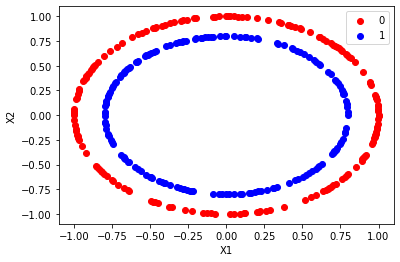

In [255]:
tfp.data.plot()

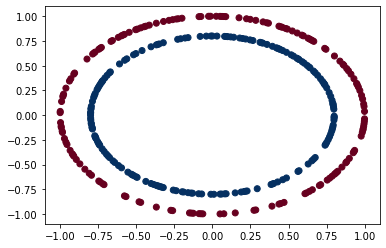

In [218]:
X_train = tfp.data.train['data'].values
y_train = tfp.data.train['label'].values

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='RdBu')

,X1,X2
567,0.968583,0.248690
944,-0.546394,0.837528
260,0.075327,-0.997159
131,-0.567269,-0.823533
275,0.702650,-0.711536
...,...,...
410,0.795961,0.080289
163,0.140018,0.787651
67,0.777305,0.189199
690,-0.797727,0.060261


In [203]:
tfp.train()

Epoch 1/10
11/11 [==============================] - 1s 2ms/step - loss: 0.6915
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6951
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6898
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6877
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6870
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6849
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6847
Epoch 8/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6795
Epoch 9/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6830
Epoch 10/10
11/11 [==============================] - 0s 2ms/step - loss: 0.6698


(<Figure size 432x288 with 1 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>], dtype=object))

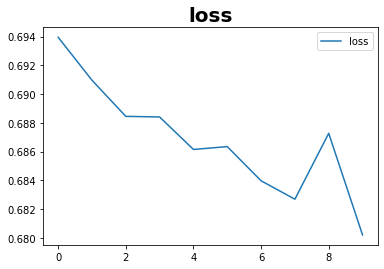

In [204]:
tfp.plot_learning_curve()